# Project to colculate roll rate and migration matrix

##Descriotion

Let's take a portfolio of 21,000 loans. We have at our disposal the number of loans in six categories for November 2022 and the distribution of the same loans by category a month later. Part of the loans remained in their categories, but there are also loans that have flowed both into the category closer to the default, and into the category of more prosperous ones.

A task:
1. Build a roll rate based on a comparison of data for November and December 2022.
2. Build a migration matrix for the whole of 2023 on a monthly basis.

##Data description


To solve problems, we will use a simulated in Excel [dataframe] (https://docs.google.com/spreadsheets/d/1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH/edit?usp=share_link&ouid=107737819750945617634&rtpof=true&sd=true) with synthetic data.
The information is already grouped into categories.
 
The total number of credits is 21000.

____________________________

Number of loans by category in November, 2022:

`0 - No debt` - 11135

`1-30` - 5667

`31-60` - 2774

`61-90` - 1112

`Default (91-∞)` - 312

`Loan repaid` - 0
_____________________________

Number remaining in loan categories in December, 2022:

`0 - No debt` - 9914

`1-30` - 219

`31-60` - 1000

`61-90` - 932

`Default (91-∞)` - 186

`Loan repaid` - 272

The rest have moved into other categories.

Data are presented in absolute numbers.

##Upload the Dataframe

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go
import numpy as np
import pylab 
import math as mth

import warnings 
warnings.filterwarnings('ignore')

In [2]:
! gdown -- 1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH

Downloading...
From: https://drive.google.com/uc?id=1KFeFdMQM1_KCyXJdPvEz8c76O4cAgfGH
To: /content/df_bank_loans.xlsx
100% 9.63k/9.63k [00:00<00:00, 14.4MB/s]


In [3]:
df = pd.read_excel('/content/df_bank_loans.xlsx', sheet_name='Sheet1')

In [4]:
df

,Категория,0 - Нет задолженности,1-30,31-60,61-90,Дефолт (91-∞),Кредит погашен,Всего
0,0 - Нет задолженности,9914,630,356,136,0,99,11135
1,1-30,5300,219,108,23,14,3,5667
2,31-60,1116,418,1000,213,15,12,2774
3,61-90,0,10,12,932,100,58,1112
4,Дефолт (91-∞),0,0,0,26,186,100,312
5,Кредит погашен,0,0,0,0,0,0,0


Here is our dataframe. The data in the "Total" column is the breakdown of loans into six categories as of November 2022. The categories for November loans are located in the "Category" column.

The names of the upper columns are the same categories, but this is the distribution of loans by category a month later, in December 2022. For clarity, let's color in the dataframe the number of loans in categories that remained unchanged compared to November.

In [5]:
def highlight_col(x): 
    r = 'background-color: grey'
    df1 = pd.DataFrame('', index=x.index, columns=x.columns)
    df1.iloc[:, 7] = r
    return df1

In [6]:
def highlighter(cell_value): 
    if cell_value in [219]:
        return "background-color: grey"

In [7]:
df.style.format().highlight_max(subset=['0 - Нет задолженности', '31-60', '61-90', 'Дефолт (91-∞)'], color='grey').apply(highlight_col, axis=None).applymap(highlighter)

,Категория,0 - Нет задолженности,1-30,31-60,61-90,Дефолт (91-∞),Кредит погашен,Всего
0,0 - Нет задолженности,9914,630,356,136,0,99,11135
1,1-30,5300,219,108,23,14,3,5667
2,31-60,1116,418,1000,213,15,12,2774
3,61-90,0,10,12,932,100,58,1112
4,Дефолт (91-∞),0,0,0,26,186,100,312
5,Кредит погашен,0,0,0,0,0,0,0


So it became easier to read your dataframe. So, in the category "No debt" in November there were 11135 loans, in December there were 9914 loans. The rest migrated into the delinquency category, and 99 loans were repaid ahead of schedule.

There were 5,667 loans in the "1-30 days" category in November, and only 219 remained in December. In 5,300 loans, the debt was repaid, and now these loans have migrated to the "No Debt" category, 3 loans have been repaid in full, the rest have migrated to neighboring categories of delay.

The principle of how to read the table is clear.

Let's check if the number of credits for November matches their number in December.

In [8]:
if df['Всего'].sum()==df.iloc[:, 1:7].sum().sum():
  print('The number of loans is the same. Credits in dataframe -', df['Всего'].sum())
else:
  print('The number of loans does not match. Loans for November 2022 -', df['Всего'].sum(), 'Loans for December 2022 - ', df.iloc[:, 1:7].sum().sum()) 


The number of loans is the same. Credits in dataframe - 21000


It's ok.


##Roll rate 


As follows from the academic literature, roll rate is a simplified subset of a wider class of models - Markov models. The analysis involves comparing categories of loans over a certain period of time, for example, in a month, quarter, half a year; as well as calculating the proportion of loans that improved or moved into the following delinquency categories.

In our situation, we compare how the distribution changed in December compared to November 2022.

Let's translate absolute numbers into relative ones and consider in percentage terms how the distribution by category has changed in one month.

In [9]:
roll_rate = df['Категория'].reset_index().drop('index', axis=1).copy()

In [10]:
roll_rate['0 - Нет задолженности, %'] = df['0 - Нет задолженности'] / df['Всего'] * 100
roll_rate['1-30, %'] = df['1-30'] / df['Всего'] * 100
roll_rate['31-60, %'] = df['31-60'] / df['Всего'] * 100
roll_rate['61-90, %'] = df['61-90'] / df['Всего'] * 100
roll_rate['Дефолт (91-∞), %'] = df['Дефолт (91-∞)'] / df['Всего'] * 100
roll_rate['Кредит погашен, %'] = df['Кредит погашен'] / df['Всего'] * 100

roll_rate = roll_rate.fillna(0) #заполнили ячейки с nan в нижней строке нулями

Let's color in the shares of the remaining in the categories of loans in comparison with the previous month.

In [11]:
def highlighter(cell_value): 
    if cell_value in [roll_rate.loc[0][1],
                      roll_rate.loc[1][2],
                      roll_rate.loc[2][3],
                      roll_rate.loc[3][4],
                      roll_rate.loc[4][5]]:
        return "background-color: grey"

In [12]:
roll_rate.style.format().applymap(highlighter)

,Категория,"0 - Нет задолженности, %","1-30, %","31-60, %","61-90, %","Дефолт (91-∞), %","Кредит погашен, %"
0,0 - Нет задолженности,89.034576,5.657836,3.197126,1.221374,0.000000,0.889088
1,1-30,93.523910,3.864479,1.905770,0.405858,0.247044,0.052938
2,31-60,40.230714,15.068493,36.049027,7.678443,0.540735,0.432588
3,61-90,0.000000,0.899281,1.079137,83.812950,8.992806,5.215827
4,Дефолт (91-∞),0.000000,0.000000,0.000000,8.333333,59.615385,32.051282
5,Кредит погашен,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Most loans did not migrate to others in the most prosperous category "No debt" (89% of November) and "61-90" days past due. The strongest migration in the category "1-30" days of delay. 93% of loans from this category migrated to a more prosperous "No debt", the debt on them was paid.

Let's try to visualize the flow of loans by category as of December 2022 compared to the previous month.

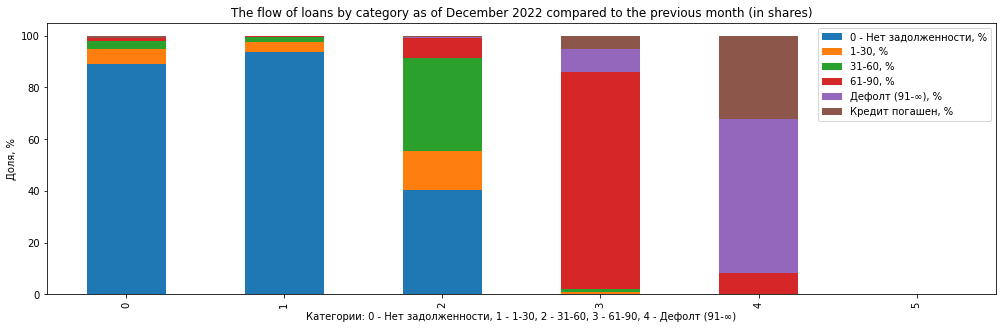

In [13]:
roll_rate.plot.bar(stacked=True, figsize=(17, 5))
plt.title('The flow of loans by category as of December 2022 compared to the previous month (in shares)')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞)')
plt.ylabel('Доля, %');

Another visualization option to see more clearly into which categories loans flowed or remained without movement in December compared to November:

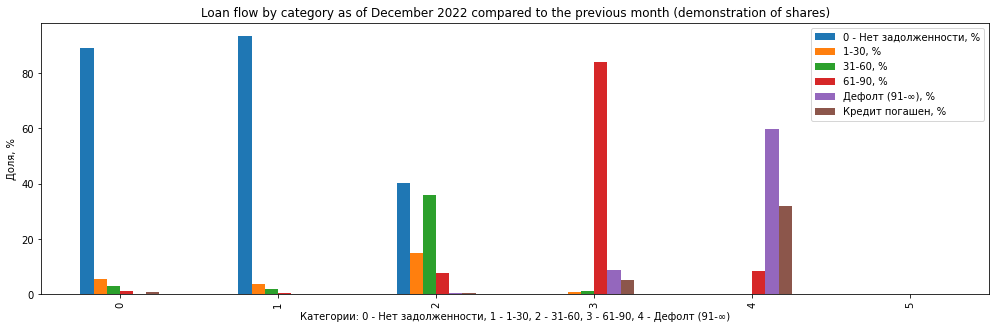

In [14]:
roll_rate.plot(kind='bar', figsize=(17, 5))
plt.title('Loan flow by category as of December 2022 compared to the previous month (demonstration of shares)')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞)')
plt.ylabel('Доля, %');

Let's calculate what share of loans in categories in December, in comparison with November, remained in the same categories; which one migrated towards category improvement, and which one moved to categories closer to default.

In [15]:
roll_rate_total = df['Категория'].reset_index().drop('index', axis=1).copy()

roll_rate_total['Переток назад, %'] = 0.0
roll_rate_total['Без изменений, %'] = roll_rate.loc[0][1]
roll_rate_total['Переток в сторону дефолта, %'] = roll_rate.iloc[:1, 2:7].sum(axis=1)

roll_rate_total['Без изменений, %'][1] = roll_rate.loc[1][2]
roll_rate_total['Без изменений, %'][2] = roll_rate.loc[2][3]
roll_rate_total['Без изменений, %'][3] = roll_rate.loc[3][4]
roll_rate_total['Без изменений, %'][4] = roll_rate.loc[4][5]

roll_rate_total['Переток в сторону дефолта, %'][1] = roll_rate.iloc[1:2, 3:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][2] = roll_rate.iloc[2:3, 4:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][3] = roll_rate.iloc[3:4, 5:7].sum(axis=1)
roll_rate_total['Переток в сторону дефолта, %'][4] = roll_rate.iloc[4:5, 6:7].sum(axis=1)

roll_rate_total['Переток назад, %'][1] = roll_rate.loc[1][1]
roll_rate_total['Переток назад, %'][2] = roll_rate.iloc[2:3, 1:3].sum(axis=1)
roll_rate_total['Переток назад, %'][3] = roll_rate.iloc[3:4, 1:4].sum(axis=1)
roll_rate_total['Переток назад, %'][4] = roll_rate.iloc[4:5, 1:5].sum(axis=1)

roll_rate_total = roll_rate_total.fillna(0)

roll_rate_total

,Категория,"Переток назад, %","Без изменений, %","Переток в сторону дефолта, %"
0,0 - Нет задолженности,0.000000,89.034576,10.965424
1,1-30,93.523910,3.864479,2.611611
2,31-60,55.299207,36.049027,8.651766
3,61-90,1.978417,83.812950,14.208633
4,Дефолт (91-∞),8.333333,59.615385,32.051282
5,Кредит погашен,0.000000,89.034576,0.000000


We visualize the data.

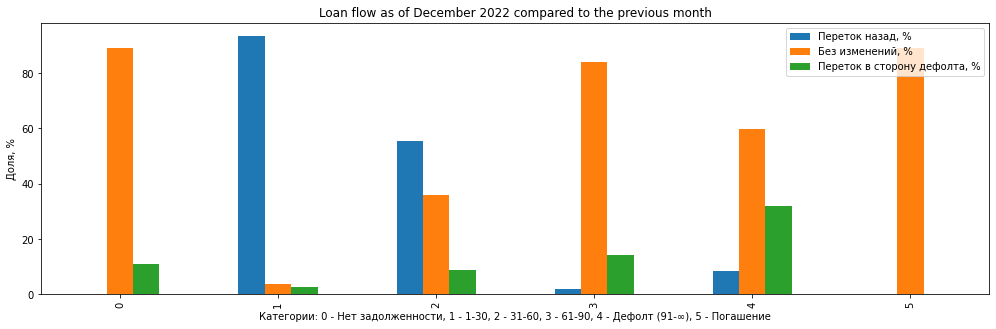

In [16]:
roll_rate_total.plot(kind='bar', figsize=(17, 5))
plt.title('Loan flow as of December 2022 compared to the previous month')
plt.xlabel('Категории: 0 - Нет задолженности, 1 - 1-30, 2 - 31-60, 3 - 61-90, 4 - Дефолт (91-∞), 5 - Погашение')
plt.ylabel('Доля, %');

Now you can immediately see what share of loans remained in their categories in December (yellow columns), what share migrated to more prosperous categories (summary data, blue columns), and what moved to riskier categories (green columns).

Let's offer another chart. The data on it is the same. The graph allows you to more clearly see the movement of flows in categories.

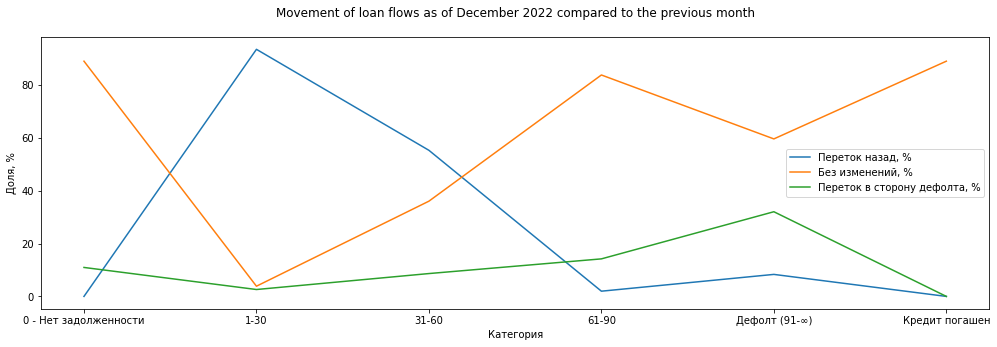

In [17]:
plt.figure(figsize=(17, 5))

plt.plot(roll_rate_total['Категория'], roll_rate_total['Переток назад, %'])
plt.plot(roll_rate_total['Категория'], roll_rate_total['Без изменений, %'])
plt.plot(roll_rate_total['Категория'], roll_rate_total['Переток в сторону дефолта, %'])

plt.title('Movement of loan flows as of December 2022 compared to the previous month', pad=20)
plt.xlabel('Категория')
plt.ylabel('Доля, %')
plt.legend(['Переток назад, %', 'Без изменений, %', 'Переток в сторону дефолта, %'])

plt.show()

Intermediate output:
More than 60% of loans remain in their categories, with the exception of the "1-30" and "31-60" overdue categories. However, in these categories, the share of flow back to more prosperous categories is the strongest.

##Migration matrix

The migration matrix is an estimate of the probability of a loan moving from one category to
another or the onset of default, or repayment of the loan within a certain period of time. We have data for the month and the task is to predict the probability of migration of loans by category for the year ahead. If the roll rate showed actual flows, the migration matrix calculates the probabilities of events based on the available observations.

It should be noted that the above-mentioned Markov chains, which include the construction of migration matrices, take into account the actual location of a loan in a particular category at a point in time and do not take into account such features as information about borrowers, the business environment, the success of servicing loans in more early periods.

To build migration matrices, that is, a forecast of keeping loans in their categories, it is necessary to transfer the dataframe into an array, from which we will build a square matrix.

The forecast is calculated by raising the matrix to a power. Monthly forecast? Then the matrix must be squared. For two months? Then in a cube. Our task is to build a forecast for the year, therefore, we will raise the matrix to the 13th power.

In [18]:
roll_rate.iloc[:, 1:7] / 100 

,"0 - Нет задолженности, %","1-30, %","31-60, %","61-90, %","Дефолт (91-∞), %","Кредит погашен, %"
0,0.890346,0.056578,0.031971,0.012214,0.000000,0.008891
1,0.935239,0.038645,0.019058,0.004059,0.002470,0.000529
2,0.402307,0.150685,0.360490,0.076784,0.005407,0.004326
3,0.000000,0.008993,0.010791,0.838129,0.089928,0.052158
4,0.000000,0.000000,0.000000,0.083333,0.596154,0.320513
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
numpy_array = (roll_rate.iloc[:, 1:7] / 100).to_numpy()
numpy_array = numpy_array.reshape(6,6) 

In [20]:
table_columns = [
    '0, %',
    '1-30, %',
    '31-60, %',
    '61-90, %',
    'Дефолт, %',
    'Погашение, %'
]

Excel uses the MMULT formula to raise a matrix to a power. Python has a function for this `np.linalg.matrix_power(A, P)`, where A is a matrix, P is a power. Let's write a loop to see what results are predicted for each month for our loan portfolio.

In [21]:
for degree in range(2,14):
    print(f"Month {degree - 1}:")
    result = np.linalg.matrix_power(numpy_array, degree)    
    result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
    result_dataframe = result_dataframe * 100
    display(result_dataframe)
    print()

Month 1:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",85.849212,5.748818,4.120086,2.379567,0.141101,0.872126
"1-30, %",87.649533,5.731592,3.755117,1.665044,0.203627,0.942150
"31-60, %",64.414670,8.359602,14.651582,9.801119,1.245025,1.095414
"61-90, %",1.275187,0.951076,1.310613,71.082016,12.906288,7.258993
"Дефолт, %",0.000000,0.074940,0.089928,11.952361,36.289341,19.542147
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 2:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",83.469542,5.721603,4.365197,3.394374,0.334589,0.953481
"1-30, %",84.909509,5.761376,4.283148,2.794616,0.305592,0.950671
"31-60, %",71.063991,6.263443,7.606253,10.264044,1.723500,1.550766
"61-90, %",2.552109,0.945618,1.298430,60.771528,14.095838,7.861657
"Дефолт, %",0.106266,0.123932,0.162829,13.048947,22.709554,12.255042
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 3:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",81.423969,5.631974,4.387908,4.250684,0.542455,1.048315
"1-30, %",82.710226,5.697225,4.398654,3.757041,0.470888,1.020207
"31-60, %",72.189390,5.501184,5.244116,10.223643,2.007100,1.755800
"61-90, %",3.679007,0.923098,1.223495,52.243771,13.877710,7.716443
"Дефолт, %",0.276026,0.152684,0.205273,12.843474,14.713041,7.961029
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 4:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",79.528014,5.523898,4.338228,4.962100,0.743283,1.141466
"1-30, %",80.738576,5.596374,4.379142,4.559200,0.656445,1.104297
"31-60, %",71.528184,5.179098,4.413606,10.042691,2.157880,1.843974
"61-90, %",4.631126,0.898005,1.140054,45.086148,12.980328,7.211420
"Дефолт, %",0.471138,0.167948,0.224332,12.010334,9.927712,5.389035
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 5:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",77.718896,5.411363,4.265321,5.547685,0.926448,1.225812
"1-30, %",78.880956,5.485197,4.315806,5.220987,0.838847,1.187943
"31-60, %",70.304135,5.002468,4.084984,9.830441,2.226209,1.873221
"61-90, %",5.421805,0.873965,1.062696,39.017471,11.801165,6.558559
"Дефолт, %",0.666798,0.174957,0.228741,10.917186,7.000138,3.813645
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 6:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",75.973576,5.298937,4.185373,6.025593,1.087630,1.298602
"1-30, %",77.097575,5.372207,4.238607,5.762847,1.006483,1.264074
"31-60, %",68.916910,4.874961,3.921728,9.617343,2.245643,1.871653
"61-90, %",6.072177,0.851540,0.994141,33.836490,10.551981,5.870773
"Дефолт, %",0.849331,0.177131,0.224923,9.759778,5.156589,2.820066
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 7:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",74.282330,5.188096,4.103767,6.411663,1.225987,1.359267
"1-30, %",75.373019,5.260180,4.157454,6.202798,1.154452,1.329816
"31-60, %",67.496871,4.765030,3.813795,9.410362,2.236867,1.853659
"61-90, %",6.602681,0.830548,0.933884,29.392646,9.340933,5.205636
"Дефолт, %",1.012347,0.176559,0.216934,8.638037,3.953452,2.170424
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 8:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",72.640042,5.079300,4.022332,6.719396,1.342473,1.408300
"1-30, %",73.700147,5.150006,4.075676,6.556116,1.281512,1.384446
"31-60, %",66.086312,4.662313,3.725157,9.210076,2.212167,1.826900
"61-90, %",7.031138,0.810710,0.880767,25.568977,8.218958,4.590142
"Дефолт, %",1.153738,0.174469,0.207150,7.598986,3.135277,1.727710
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 9:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",71.043326,4.972674,3.941717,6.960271,1.438881,1.446675
"1-30, %",72.074774,5.041955,3.994425,6.835671,1.388319,1.428313
"31-60, %",64.698702,4.563379,3.643988,9.015701,2.178697,1.795558
"61-90, %",7.372690,0.791795,0.833677,22.271823,7.205898,4.034668
"Дефолт, %",1.273733,0.171569,0.196890,6.660913,2.554021,1.412493
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 10:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",69.489543,4.868232,3.862174,7.144064,1.517317,1.475537
"1-30, %",70.493889,4.936089,3.914127,7.052346,1.476425,1.462268
"31-60, %",63.338067,4.467068,3.566381,8.826419,2.140581,1.761952
"61-90, %",7.640156,0.773642,0.791680,19.424438,6.305149,3.540818
"Дефолт, %",1.373732,0.168265,0.186850,5.826914,2.123081,1.178285
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 11:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",67.976461,4.765953,3.783816,7.279134,1.579917,1.496050
"1-30, %",68.955039,4.832403,3.834958,7.215386,1.547740,1.487350
"31-60, %",62.005336,4.372967,3.491025,8.641631,2.100179,1.727378
"61-90, %",7.844419,0.756139,0.754018,16.962867,5.511833,3.105788
"Дефолт, %",1.455635,0.164782,0.177365,5.092440,1.791112,0.997507
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000



Month 12:


,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %"
"0, %",66.502115,4.665800,3.706702,7.372645,1.628706,1.509313
"1-30, %",67.456110,4.730867,3.757003,7.332683,1.604232,1.504632
"31-60, %",60.700421,4.280910,3.417463,8.460942,2.058835,1.692566
"61-90, %",7.994763,0.739208,0.720075,14.833174,4.817284,2.724773
"Дефолт, %",1.521484,0.161247,0.168571,4.449450,1.527098,0.853484
"Погашение, %",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


12 migration matrixes with a forecast for the year are ready. Thus, by the 12th month, the probability that customers who had no debt in the previous month will remain in the No Debt category is 66.5%. Recall that as of December 2022, according to available data, this probability was 89%.

Find the average for each category for each month of the forecast to visualize trends.

In [22]:
result = np.linalg.matrix_power(numpy_array, 2)    
result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
result_dataframe = result_dataframe * 100
migration_matrix_avg = result_dataframe.describe().iloc[1:2,:] 

In [23]:
#we take the data of the average values for each column in each of the 12 months
for degree in range(3,14):
    result = np.linalg.matrix_power(numpy_array, degree)    
    result_dataframe = pd.DataFrame(result, columns=table_columns, index=table_columns)
    result_dataframe = result_dataframe * 100
    migration_matrix_avg = migration_matrix_avg.append((result_dataframe.describe().iloc[1:2,:]), ignore_index=True)    
                                                                                                         

In [24]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

In [25]:
migration_matrix_avg['Месяц'] = months

In [26]:
migration_matrix_avg

,"0, %","1-30, %","31-60, %","61-90, %","Дефолт, %","Погашение, %",Месяц
0,39.864767,3.477671,3.987888,16.146684,8.464230,4.951805,January
1,40.350236,3.135995,2.952643,15.045585,6.528179,3.928603,February
2,40.046436,2.984361,2.576574,13.886436,5.268532,3.250299,March
3,39.482840,2.894220,2.415894,12.776745,4.410941,2.781699,April
4,38.832098,2.824658,2.326258,11.755628,3.798801,2.443197,May
5,38.151595,2.762463,2.260795,10.833675,3.341388,2.187528,June
6,37.461208,2.703402,2.204306,10.009251,2.985282,1.986467,July
7,36.768563,2.646133,2.151847,9.275592,2.698398,1.822916,August
8,36.077204,2.590229,2.101783,8.624063,2.460969,1.686284,September
9,35.389231,2.535549,2.053535,8.045697,2.260426,1.569810,October


##Visualize the averaged data from the migration matrixes

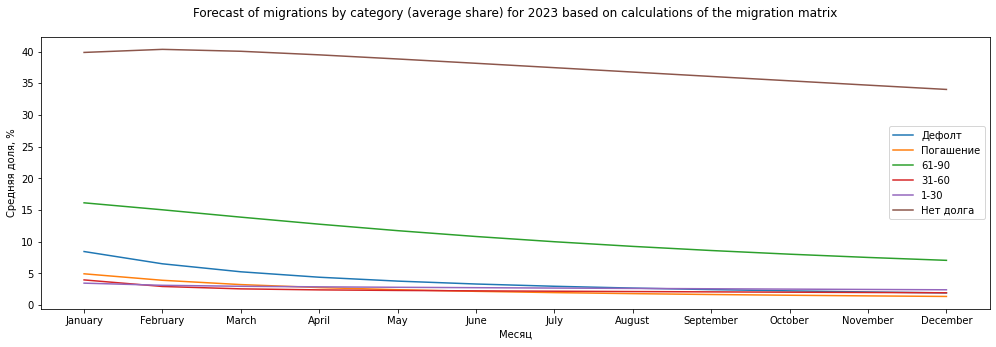

In [27]:
plt.figure(figsize=(17, 5))

plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Дефолт, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Погашение, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['61-90, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['31-60, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['1-30, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['0, %'])

plt.title('Forecast of migrations by category (average share) for 2023 based on calculations of the migration matrix', pad=20)
plt.xlabel('Месяц')
plt.ylabel('Средняя доля, %')
plt.legend(['Дефолт', 'Погашение', '61-90', '31-60', '1-30', 'Нет долга'])

plt.show()

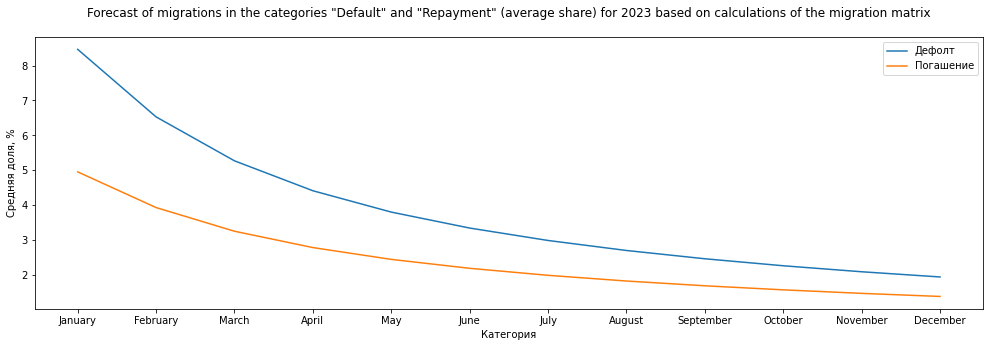

In [28]:
plt.figure(figsize=(17, 5))

plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Дефолт, %'])
plt.plot(migration_matrix_avg['Месяц'], migration_matrix_avg['Погашение, %'])

plt.title('Forecast of migrations in the categories "Default" and "Repayment" (average share) for 2023 based on calculations of the migration matrix', pad=20)
plt.xlabel('Категория')
plt.ylabel('Средняя доля, %')
plt.legend(['Дефолт', 'Погашение'])

plt.show()

##Conclusion

- roll rate showed that more than 60% of loans remain in their categories for the month of observation, except for the categories of delay "1-30" and "31-60" days. However, in these categories, the share of flow back to more prosperous categories is the strongest.
- According to the curves of the life cycle of our loan portfolio for the next year, there are noticeable trends in reducing the probability of default and early repayment.
- The probability that a loan from the "No Debt" category will remain in it has decreased by 5 p.p. over the 12th month.
- The probability curves on the graph with a range of one year are descending. The academic literature confirms that "the approach based on migration matrixes, does not demonstrate high accuracy over long horizons, and also needs additional assumptions related to the issue of accounting for cases of debt restructuring.